In [27]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Set random seed for reproducibility
sionna.config.seed = 42

# Load the required Sionna components
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.channel import AWGN

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [29]:
class System_Model(tf.keras.Model):
    """System model for channel coding BER simulations.

    This model allows to simulate BERs over an AWGN channel with
    QAM modulation. Arbitrary FEC encoder/decoder layers can be used to
    initialize the model.

    Parameters
    ----------
        k: int
            number of information bits per codeword.

        n: int
            codeword length.

        num_bits_per_symbol: int
            number of bits per QAM symbol.

        encoder: Keras layer
            A Keras layer that encodes information bit tensors.

        decoder: Keras layer
            A Keras layer that decodes llr tensors.

        demapping_method: str
            A string denoting the demapping method. Can be either "app" or "maxlog".

        sim_esno: bool
            A boolean defaults to False. If true, no rate-adjustment is done for the SNR calculation.

         cw_estiamtes: bool
            A boolean defaults to False. If true, codewords instead of information estimates are returned.
    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.

        ebno_db: float or tf.float
            A float defining the simulation SNR.

    Output
    ------
        (u, u_hat):
            Tuple:

        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.
    """
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol):

        super().__init__()

        # number of bit per QAM symbol
        self.num_bits_per_symbol = num_bits_per_symbol
        
        # store values internally
        # Transport block Config
        if self.num_bits_per_symbol == 2: # QPSK
            self.k = 449
        elif self.num_bits_per_symbol == 4: # 16QAM
            self.k = k
        elif self.num_bits_per_symbol == 6: # 64QAM
            self.k = 466*2
        elif self.num_bits_per_symbol == 8: # 256QAM
            self.k = 711
        elif self.num_bits_per_symbol == 10: # 1024QAM
            self.k = 853*2

        self.n = n

        # init components
        self.source = BinarySource()

        # initialize mapper and demapper for constellation object
        self.constellation = Constellation("qam",
                                num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper("app",
                                 constellation=self.constellation)

        # the channel can be replaced by more sophisticated models
        self.channel = AWGN()

        # FEC encoder / decoder
        self.encoder = LDPC5GEncoder(k=self.k, n=self.n)
        self.decoder = LDPC5GDecoder(self.encoder, num_iter=10)

    @tf.function() # enable graph mode for increased throughputs
    def call(self, batch_size, ebno_db):

        
        no = ebnodb2no(ebno_db,
                        num_bits_per_symbol=self.num_bits_per_symbol,
                        coderate=self.k/self.n)

        u = self.source([batch_size, self.k]) # generate random data
        c = self.encoder(u) # explicitly encode

        x = self.mapper(c) # map c to symbols x

        y = self.channel([x, no]) # transmit over AWGN channel

        llr_ch = self.demapper([y, no]) # demap y to LLRs

        u_hat = self.decoder(llr_ch) # run FEC decoder (incl. rate-recovery)

        return u, u_hat

In [30]:
n_bits_per_symbol = [2,4,6,8,10]
k = [378, 490, 616]
batch_size = 128
ebno_db = np.linspace(-10, 30, num=81)

BER1 = []
BER2 = []

BLER1 = []
BLER2 = []

In [31]:
# run ber simulations for each code we have added to the list
for num_bits_per_symbol in n_bits_per_symbol:

    if num_bits_per_symbol == 2 or num_bits_per_symbol == 4 or num_bits_per_symbol == 8:
        n = 1024
    elif num_bits_per_symbol == 6:
        n = 2046
    elif num_bits_per_symbol == 10:
        n = 2040
        
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k[0],
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol)

    ber, bler = sim_ber(model,
                        ebno_db,
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER1.append(list(ber.numpy()))
    BLER1.append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.0964e-01 | 1.0000e+00 |       47086 |      114944 |          256 |         256 |         0.9 |reached target block errors
     -9.5 | 4.0622e-01 | 1.0000e+00 |       46693 |      114944 |          256 |         256 |         0.1 |reached target block errors
     -9.0 | 3.9847e-01 | 1.0000e+00 |       45802 |      114944 |          256 |         256 |         0.1 |reached target block errors
     -8.5 | 3.9247e-01 | 1.0000e+00 |       45112 |      114944 |          256 |         256 |         0.1 |reached target block errors
     -8.0 | 3.8852e-01 | 1.0000e+00 |       44658 |      114944 |          256 |         256 |         0.1 |reached target block errors
     -7.5 | 3.7976e-01 | 1.0000e+00 |       43651 |      114944 |

In [43]:
for k2 in k:
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k2,
                         n=1024,
                         num_bits_per_symbol=n_bits_per_symbol[1])

    ber, bler = sim_ber(model,
                        ebno_db,
                        batch_size=128,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER2.append(list(ber.numpy()))
    BLER2.append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.3755e-01 | 1.0000e+00 |       42341 |       96768 |          256 |         256 |         0.9 |reached target block errors
     -9.5 | 4.3491e-01 | 1.0000e+00 |       42085 |       96768 |          256 |         256 |         0.1 |reached target block errors
     -9.0 | 4.3197e-01 | 1.0000e+00 |       41801 |       96768 |          256 |         256 |         0.1 |reached target block errors
     -8.5 | 4.2368e-01 | 1.0000e+00 |       40999 |       96768 |          256 |         256 |         0.1 |reached target block errors
     -8.0 | 4.2804e-01 | 1.0000e+00 |       41421 |       96768 |          256 |         256 |         0.1 |reached target block errors
     -7.5 | 4.1803e-01 | 1.0000e+00 |       40452 |       96768 |

In [45]:
BER1 = np.array(BER1)
BER2 = np.array(BER2)

np.save('data/BER_modulation.npy', BER1)
np.save('data/BER_coderate.npy', BER2)

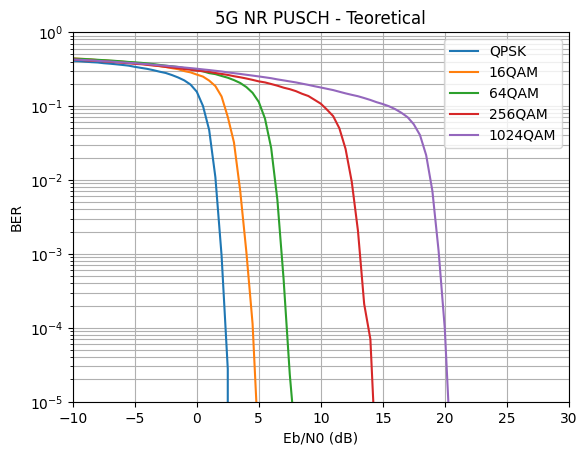

In [34]:
plt.figure()
plt.title("5G NR PUSCH - Teoretical")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([ebno_db[0], ebno_db[-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for num_bits_per_symbol in n_bits_per_symbol:
    
    plt.semilogy(ebno_db, BER1[i])
    i += 1
    if num_bits_per_symbol == 2:
        legend.append("QPSK")
    else:
        legend.append(str(2 ** num_bits_per_symbol) + "QAM")
    
plt.legend(legend);

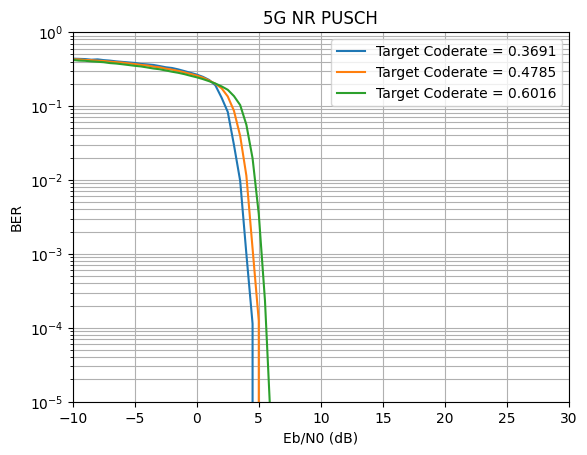

In [44]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([ebno_db[0], ebno_db[-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for k2 in k:
    
    plt.semilogy(ebno_db, BER2[i])
    i += 1

    cr = k2/1024
    
    legend.append("Target Coderate = " + str('%.4f' % cr))
   
plt.legend(legend);